### Implementazione di Convolutional Neural Network, tuning degli iperparmetri, confronto con una CNN stato dell'arte + transfer learning  

### Informazioni ###

scopo: familiarizzare con l'utilizzo del tool Tensorflow/Keras per lo sviluppo di CNN 

applicazione: predizione temperatura di configurazioni del modello di Ising ferromagnetico 2D

DL tool: tensorflow/keras

### Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È definito su un reticolo bidimensionale dall'Hamiltoniana 

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si dimostra che questo sistema presenta una transizione di fase nel limite termodinamico da un sistea ordinato con tutti gli spin allineati (ferromagnete ordinato) a una fase disordinata con spin random, alla temperatura critica $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$. 


**Dataset:**

10k configurazioni (simulate con termalizzazioni non complete in modo da avere un certo livello di "rumore") con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis 

NOTA: le configurazioni sono 28x28 valori dello spin, le label sono la temperatura associata ad ogni configurazione.

In [0]:
# download del dataset:
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
!wget http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat

--2020-05-07 17:48:06--  http://www.roma1.infn.it/~giagu/datasets/ising2_label.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81025 (79K)
Saving to: ‘ising2_label.dat’

ising2_label.dat    100%[===================>]  79.13K   253KB/s    in 0.3s    

2020-05-07 17:48:07 (253 KB/s) - ‘ising2_label.dat’ saved [81025/81025]

--2020-05-07 17:48:09--  http://www.roma1.infn.it/~giagu/datasets/ising2_conf.dat
Resolving www.roma1.infn.it (www.roma1.infn.it)... 141.108.26.1, 141.108.26.150
Connecting to www.roma1.infn.it (www.roma1.infn.it)|141.108.26.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19060775 (18M)
Saving to: ‘ising2_conf.dat’

ising2_conf.dat     100%[===================>]  18.18M  9.36MB/s    in 1.9s    

2020-05-07 17:48:11 (9.36 MB/s) - ‘ising2_conf.dat’ saved [19060775/19060775

### Procedura ###

Passi tipici nella costruzione di una procedura end-to-end per lo sviluppo di una CNN (o generica DNN):

1.   lettura e pre-processamento dei dati
2.   definizionedel modello di ANN e della sua architettura
3.   scelta dell'ottmizzatore e della funzione di loss
4.   training del modello
5.   misura delle prestazioni del modello su dati non utilizzati nel training (test data)
6.   modifica degli iperparametri per ottimizzare le prestazioni per il dataset specifico (hyperparameter tuning)

In [0]:
#import models & layers from TF/keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-rc4


In [0]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Le reti neurali non processano direttamente dati "raw" come per esempio immagini JPEG o file di testo, o file CSV. Si aspettano in input rappresentazioni numeriche vettorizzate e standardizzate


*   file con testo devono essere convertiti in tensori di stringhe, poi separati in parole, e infine ogni parola deve essere indicizzata e trasformata in tensori di interi

*   le immagini devono essere convertite in tenosri di numeri reali ed eventualmente normalizzate a vlaori piccoli (spesso in [0,1])

*   dati in formato CSV devono essere letti e decodificati (per esempio con pandas). Ogni feature poi eventualmente dovrebbe essere normalizzata (non obbligatorio ma utile) in modo da avere media zero e varianza unitaria

etc. etc.

Keras accetta input in forma di numpy array oopure in formati specializzati di tensorflow (tf dataset objects) utili nel caso di grandi campioni che non entrano in memoria e per i quali si deve attuare una lettura a batch dallo storage del disco rigido. 

Keras ha anche varie utility che permettono di leggere automaticamente immagini o file di testo e convertirli nei formati utili (vedere per esempio tf.keras.preprocessing.image_dataset_from_directory o tf.keras.preprocessing.text_dataset_from_directory). 

In questa esercitazione useremo semplicemente numpy

In [0]:
#leggiamo le configurazioni ising dal file usando numpy (10k esempi oguno da 28x28 spin)
data = np.loadtxt('ising2_conf.dat')
#riformattiamo i vettori in modo che abbiano la struttura di matrici di 28x28 spin
# (le configurazioni sono scritte nel file come 10000*28 righe ognuna di 28 elementi)
data = data.reshape(10000,28,28)
print('Formato data: ', data.shape)

#leggiamo le label associate:
labels = np.loadtxt('ising2_label.dat')
print('Formato labels:', labels.shape)

Formato data:  (10000, 28, 28)
Formato labels: (10000,)


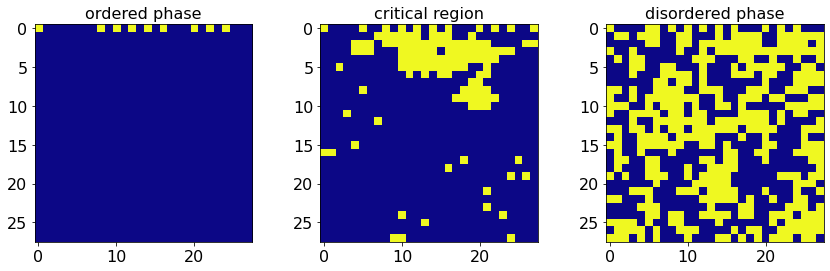

In [0]:
#Data esploration: visulaizzazione dei campioni
%matplotlib inline 

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# selezioniamo configurazioni sotto la temperatura critica (stato ordinato), 
# sopra la temp. critica (stato disordinato), e intorno alla temperatura 
# critica (stato critico)
ord_sele = (labels < 2.0)
dis_sele = (labels > 2.5)
cri_sele = ((labels >= 2.0) & (labels <= 2.5))

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(data[ord_sele][1],**cmap_args)
axarr[0].set_title('ordered phase',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(data[cri_sele][7],**cmap_args)
axarr[1].set_title('critical region',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(data[dis_sele][5],**cmap_args)
axarr[2].set_title('disordered phase',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

In [0]:
# Preprocessamento dei dati: 
# in questo caso specifico non serve normalizzare i dati visto che sono già valori 
# binari compresi nell'intervallo [-1,1]
# non è nemmeno necessario agire sulle label (T) per esempio convertendole in 
# formato vettori one-hot visto che siamo interesati ad addestrare la CNN per 
# una task di regressione (predire la temperatura di una configurazione del modello
# rappresentata da un'immagine binaria  

# unica cosa utile è quella di convertire in formato fp32 i valori degli spin (-1, 1):

data = data.astype('float32')
labels = labels.astype('float32')

# se avessimo voluto normalizzare le immagini tra [0,1]:
# o usare scikit-learn sklearn.preprocessing.MinMaxScaler
data_max = np.amax(data)
data_min = np.amin(data)
print('min/max data: %f / %f' % (data_min, data_max))
data_norm = (data.astype('float32')-data_min) / (data_max-data_min)
print('min/max normalized data: %f / %f' % (np.amin(data_norm), np.amax(data_norm)))

# se avessimo voluto normalizzare le immagini a media 0 e varianza 1
# o usare scikit-learn sklearn.preprocessing.normalize
from tensorflow.keras.layers.experimental.preprocessing import Normalization
normalizer = Normalization(axis=-1)
normalizer.adapt(data)
data_norm = normalizer(data)
print('var normalized data: %.4f' % np.var(data_norm))
print('mean normalized data: %.4f' % np.mean(data_norm))

min/max data: -1.000000 / 1.000000
min/max normalized data: 0.000000 / 1.000000
var normalized data: 1.0000
mean normalized data: -0.0000


In [0]:
# se avessimo voluto codificare le label usando one_hot encoding (builtin in keras)
# NOTA: non ha senso in questo caso con label target continui ...
# labels_onehot = keras.utils.to_categorical(labels)

In [0]:
# dividiamo il campione in training e test sets

from sklearn.model_selection import train_test_split
train_to_test_ratio=0.8 # training samples

X_train,X_test,Y_train,Y_test=train_test_split(data,labels,train_size=train_to_test_ratio)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
data = (X_train,X_test,Y_train,Y_test)

(8000, 28, 28)
(2000, 28, 28)
(8000,)
(2000,)


**Creazione del Modello CNN**

Usiamo functional API di Keras

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

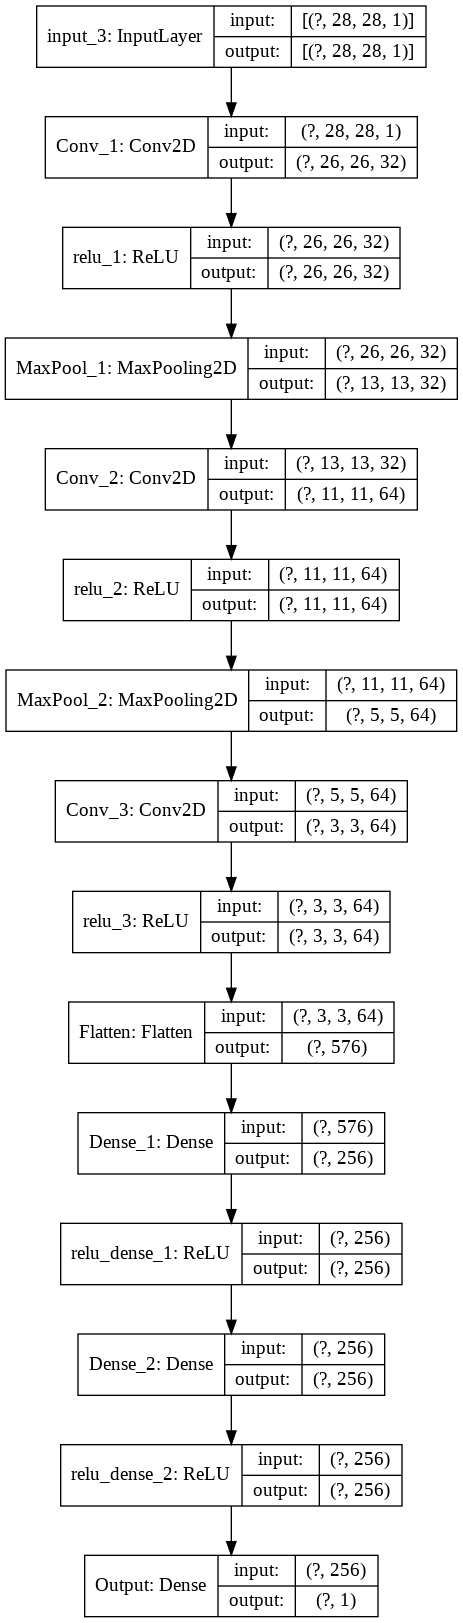

In [0]:
# Model definition (functional model)

# definizione input (tensori 28 spin x 28 spin x 1)
inputs = keras.Input(shape=(28,28,1))

# Data Augmentation
# è spesso utile applicare variazioni random ai dati che siano coerenti con le 
# simmetrie del problema per rendere il modello più robusto e con maggiore 
# capacità di generalizzazione
# In questo caso per esempio e' possibile fare dei filipping random orizzontali 
# o verticali dei pixel (spin) senza cambiare il contenuto fisico delle config.
# Se lo volessimo fare in TF/keras basta generare un layer di data-augmentation

data_augmentation = keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip()
], name='DataAugm')

#ed aggiungerlo al modello come primo layer dopo l'input ...
# NOTA: il sistema è intelligente e le trasformazioni vengono atuate SOLO durante 
# il training ma non durante uso del modello in prediction/test 

# Image augmentation block scomentare la riga che segue (e commentare la successiva) 
# per attivarlo
def output_from_input(
    inputs, data_augment=False, activation="relu",
    batch_normalize=False
):
  if activation=="relu":
    _layer_with_activation = keras.layers.ReLU
  elif activation=="l_relu":
    _layer_with_activation = keras.layers.LeakyReLU
  elif activation=="elu":
    _layer_with_activation = keras.layers.ELU

  if data_augment:
    x = data_augmentation(inputs)
  else:
    x = inputs

  if batch_normalize:
    layer_with_activation = lambda name, x: \
      keras.layers.BatchNormalization()(_layer_with_activation(name=name)(x))
  else:
    layer_with_activation = lambda name, x: \
      _layer_with_activation(name=name)(x)
  # CNN costituita da 3 blocchi convoluzionali per la feature selection, seguiti 
  # da una rete densa come classificatore

  #
  # singolo blocco convoluzionale: conv2D + maxPooling 
  # attvazione: ReLu

  # primo blocco convoluzionale: x -> Conv2D -> x -> ReLU -> x -> MaxPooling2D
  #tf.keras.layers.Conv2D(
  #    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
  #    dilation_rate=(1, 1), activation=None, use_bias=True,
  #    kernel_initializer='glorot_uniform', bias_initializer='zeros',
  #    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
  #    kernel_constraint=None, bias_constraint=None, **kwargs
  #)
  #tf.keras.layers.ReLU(
  #    max_value=None, negative_slope=0, threshold=0, **kwargs
  #)
  #tf.keras.layers.MaxPool2D(
  #    pool_size=(2, 2), strides=None, padding='valid', data_format=None, **kwargs
  #)
  # NOTA: padding = 'valid' -> no padding,  = 'same' -> padding aggiunto per non 
  # ridurre la size dell'immagine dopo lapplicazione del filtro

  #
  # primo blocco Convoluzionale
  x = keras.layers.Conv2D(32, kernel_size=(3,3), name='Conv_1')(x)
  x = layer_with_activation(f'{activation}_1', x)
  x = keras.layers.MaxPool2D((2,2), name='MaxPool_1')(x)

  # secondo blocco convoluzionale
  x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_2')(x)
  x = layer_with_activation(f'{activation}_2', x)
  x = keras.layers.MaxPool2D((2,2), name='MaxPool_2')(x)

  # terzo blocco convoluzionale (non applichiamo il maxpooling per non ridurre 
  # troppo la dimensione dell'output x)
  x = keras.layers.Conv2D(64, kernel_size=(3,3), name='Conv_3')(x)
  x = layer_with_activation(f'{activation}_3', x)

  # appiattimento del tensore x di uscita dell'ultimo layer convoluzionale in un 
  # vettore piatto come input per la rete densa

  x = keras.layers.Flatten(name='Flatten')(x)

  # rete densa: 2 layer hidden densi da 256 neuroni con attivazione ReLU + 1 
  # layer di uscita costituito da 1 neurone con funzione di attivazione lineare
  # che produce in output la stima della temperatura associata alla configurazione
  # in input

  # Layer denso in Keras
  #tf.keras.layers.Dense(
  #    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
  #    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
  #    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
  #    **kwargs
  #)
  x = keras.layers.Dense(256, name='Dense_1')(x)
  x = layer_with_activation(f'{activation}_dense_1', x)
  x = keras.layers.Dense(256, name='Dense_2')(x)
  x = layer_with_activation(f'{activation}_dense_2', x)
  outputs = keras.layers.Dense(1, name='Output')(x)
  return outputs

outputs = output_from_input(inputs)
#definizione del modello
model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

#printout il summary del modello
model.summary()

# struttura el modello
keras.utils.plot_model(model, show_shapes=True)

In [0]:
#Compilazione del Modello

# Definizione dei parametri di training del modello:
# * Loss function: 
# * Optimizer:
# * Metric: 

# Parametri:

# learning rate per Adam
LR_ST=1e-3

# Ottimizzatore: 
#adam: adaptive moment estimation (SGD con learning adattivo del gradiente e 
# del momento secondo + momentum )
#tf.keras.optimizers.Adam(
#    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#    name='Adam', **kwargs
#)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

# Loss function:
# siamo interessati ad una task di regressione: una loss appropriata è la MSE
# (mean squared error) che minimizza la distanza quadratica tra predizione 
# della rete e target = 1/N sum (y_pred - t_true)^2
# loss: mse

mse = tf.keras.losses.MeanSquaredError()

# Metrica:
# visto che la MSE viene monitorata come loss, può essere utile monitorare la 
# MAE (mean absolute error) = 1/N sum |y_pred - t_true|
# metric: mae

mae = tf.keras.metrics.MeanAbsoluteError()

# Eagerly RUN:
# di default Tensorflow ottimizza in modo spinto il modello che abbiamo progettato
# e trasforma il modello in un grafo diretto acicliclo computazionale altamente 
# ottimizzato per girare nel minor tempo possibile. Questo significa che non è 
# il codice python che abbiamo scritto sopra ad essere in realtà esegeuito. Questo
# può creare difficoltà con il debugging se ci sono problemi. Se sidesidera 
# eseguire esattamente il python scritto basta settare run_eagerly=True. Il prezzo
# da pagare è una esecuzioen estremamente più lenta (is usa solo in debug) 

EAGERLY = False

model.compile(optimizer=OPTIMIZER,
              loss=mse,
              metrics=[mae],
              run_eagerly=EAGERLY)

In [0]:
# TRAINING

# Parametr: frazione eventi validation set, batch size, numero epoche, ...

# Callbacks:
# tramite le callbacks possiamo interagire durante il run-time con il modello.
# Per esempio possiamo modificare il larnign rate facendolo decadere (diminuire) 
# nel tempo, o possiamo dire al modello di salvare i pesi ad ogni epoca o quando 
# la validation loss raggiunge il suo valore minimo etc..
# Le callback vengono chiamate all'inizio di ogni epoca o all'inizio di ogni 
# mini-batch a seconda dello scopo ...

# callback per avere un leraning rate variabile

# callback per salvare il modello (solo i pesi in queto caso) ad ogni epoca
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='mycnn_{epoch}',
        save_weights_only=True, 
        save_freq='epoch')

# metto tutte le callback in una lista
#callbacks = [ lr_scheduler, model_checkpoint ]
callbacks = [ 
  model_checkpoint, 
  #lr_scheduler,
]
    

history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=1,
                    callbacks=callbacks)

Epoch 1/30
50/50 [==============================] - 1s 19ms/step - loss: 0.6108 - mean_absolute_error: 0.5752 - val_loss: 0.2322 - val_mean_absolute_error: 0.4137
Epoch 2/30
50/50 [==============================] - 1s 14ms/step - loss: 0.2191 - mean_absolute_error: 0.3962 - val_loss: 0.1925 - val_mean_absolute_error: 0.3685
Epoch 3/30
50/50 [==============================] - 1s 14ms/step - loss: 0.1983 - mean_absolute_error: 0.3695 - val_loss: 0.1928 - val_mean_absolute_error: 0.3569
Epoch 4/30
50/50 [==============================] - 1s 13ms/step - loss: 0.1628 - mean_absolute_error: 0.3293 - val_loss: 0.1488 - val_mean_absolute_error: 0.3126
Epoch 5/30
50/50 [==============================] - 1s 13ms/step - loss: 0.1348 - mean_absolute_error: 0.2966 - val_loss: 0.1332 - val_mean_absolute_error: 0.2981
Epoch 6/30
50/50 [==============================] - 1s 13ms/step - loss: 0.1266 - mean_absolute_error: 0.2857 - val_loss: 0.1296 - val_mean_absolute_error: 0.2898
Epoch 7/30
50/50 [====

In [0]:
model.load_weights("mycnn_29")
model.save("/content/drive/My Drive/Colab Notebooks/mycnn_29.hdf5")

In [0]:
# model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/mycnn_29.hdf5")

In [0]:
#checks accuracy and loss on test sample

test_loss, test_mae = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

63/63 - 0s - loss: 0.0945 - mean_absolute_error: 0.2320

Test loss (MSE): 0.09447386860847473

Test MAE: 0.23198005557060242


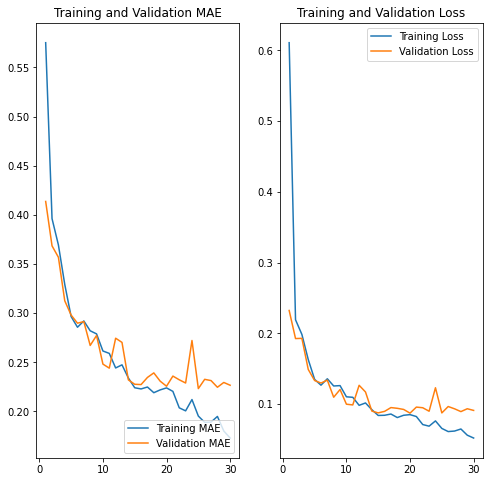

In [0]:
#plot della loss e della MAE durante il training
def plot_history(history):
  train_mae = history.history['mean_absolute_error']
  val_mae = history.history['val_mean_absolute_error']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(1, len(loss) + 1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_mae, label='Training MAE')
  plt.plot(epochs_range, val_mae, label='Validation MAE')
  plt.legend(loc='lower right')
  plt.title('Training and Validation MAE')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
plot_history(history)

In [0]:
#esempio uso della rete in predizione

predictions = model.predict(X_test[:10,:])

average_abs_diff = 0.0
for i in range(predictions.shape[0]):
  print('Predicted vs True T: %f VS %f Diff= %f' % (predictions[i],Y_test[i],predictions[i]-Y_test[i] ))
  average_abs_diff = average_abs_diff + abs(predictions[i]-Y_test[i])

print('Sample MAE: ', average_abs_diff/10.)

Predicted vs True T: 3.110633 VS 3.114210 Diff= -0.003577
Predicted vs True T: 1.720218 VS 1.887960 Diff= -0.167742
Predicted vs True T: 2.939954 VS 2.701660 Diff= 0.238294
Predicted vs True T: 1.547025 VS 1.556840 Diff= -0.009815
Predicted vs True T: 3.484708 VS 3.394530 Diff= 0.090178
Predicted vs True T: 2.940617 VS 2.890170 Diff= 0.050447
Predicted vs True T: 3.946446 VS 4.469660 Diff= -0.523213
Predicted vs True T: 1.830429 VS 1.596210 Diff= 0.234219
Predicted vs True T: 2.369776 VS 2.215780 Diff= 0.153996
Predicted vs True T: 4.278232 VS 4.072530 Diff= 0.205702
Sample MAE:  [0.16771834]


In [0]:
#Vediamo l'accuracy della rete usata come classificatore per selezionare configurazioni con T><Tc
def classify(model, X_test, Y_test, T_c):
  T_c=2.26 # Temperatura critica

  # predizioni della CNN sull'intero campione di Test
  predictions = model.predict(X_test)


  # conto i casi in cui la T predetta e la T true sono emtrambe <T_c o >= T_c
  N_ord_corrette = 0 
  N_dis_corrette = 0
  N_all = 0
  for i in range(predictions.shape[0]):
    if ((predictions[i] < T_c) & (Y_test[i] < T_c)):
      N_ord_corrette = N_ord_corrette + 1
    if ((predictions[i] >= T_c) & (Y_test[i] >= T_c)):
      N_dis_corrette = N_dis_corrette + 1

  N_all = Y_test.shape[0]   

  accuracy = (N_ord_corrette+N_dis_corrette)/N_all
  print('Accuracy is: ', accuracy)

classify(model, X_test, Y_test, 2.26)

Accuracy is:  0.9795


# **Compiti:** 

1.   ripetere il training attivando la call-back del learning rate con decay e valutare se ci sono miglioramenti
2.   ripetere il training attivando il layer con data-augmentation e valutare se ci sono miglioramenti
3.   provate a usare funzioni di attivazione diverse da ReLU: *keras.layers.Activation('tanh'), keras.layers.LeakyReLU(), keras.layers.ELU()*, ...
3.   provare ad implementare una semplice procedura di ottimizzazione degli iperparametri usando Keras Tuner (vedi istruzioni nel blocco successivo)
4.   provare ad inserire nella rete *batch normalisation* layers prima dei layer ReLu (vedi spiegazione e istruzioni alla fine del notebook)

# Exponential learning rate decay

Definisco una funzione (riutilizzabile per gli altri casi) che crea il modello, lo allena e ne verifica le prestazioni. 

In [0]:
def create_model_and_train(
    X_train, X_test, Y_train, Y_test, 
    optional_callbacks, **kwargs
):
  outputs = output_from_input(inputs, **kwargs)
  #definizione del modello
  model = keras.Model(inputs=inputs, outputs=outputs, name='ising_CNN')

  #printout il summary del modello
  model.summary()

  # struttura el modello
  keras.utils.plot_model(model, show_shapes=True)

  OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
  mse = tf.keras.losses.MeanSquaredError()
  mae = tf.keras.metrics.MeanAbsoluteError()

  model.compile(
      optimizer=OPTIMIZER,
      loss=mse,
      metrics=[mae]
)

  model_checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.hdf5", monitor='val_loss', verbose=1,
    save_weights_only=True,
    save_best_only=True, mode='auto', save_freq="epoch")

  callbacks = [model_checkpoint] + optional_callbacks
  history = model.fit(X_train, Y_train, epochs=30, batch_size=128,
                      validation_split=0.2, shuffle=True, verbose=2,
                      callbacks=callbacks)

  model.load_weights("best_model.hdf5")
  test_loss, test_mae = model.evaluate(X_test, Y_test, verbose=2)
  print('\nTest loss (MSE):', test_loss)
  print('\nTest MAE:', test_mae)
  plot_history(history)
  classify(model, X_test, Y_test, 2.26)
  return (history, model)

Alleno la rete con learning rate decay esponenziale (dalla 10° epoca).

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

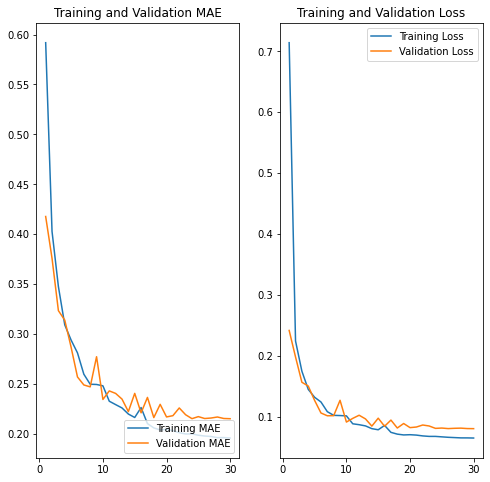

Accuracy is:  0.9795


(<tensorflow.python.keras.callbacks.History at 0x7fc2f102a828>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f0022668>)

In [0]:
LR_ST = 1e-3
# Definisco una funzione che mantiene il learning rate costante a LR_ST per le 
# prime 10 epoche e poi lo diminuisce esponenzialmente
def lr_decay(epoch):
  if epoch < 10:
    eta = LR_ST
  else:
    eta = LR_ST * tf.math.exp(0.2 * (10 - epoch))
  print(f"learning rate: {float(eta)}")
  return eta

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

create_model_and_train(*data, [lr_scheduler])

Le prestazioni sono leggermente migliorate. Si può notare dal grafico di MAE e loss come gli andamenti siano diventati asintoticamente piatti. Ritengo che effettuando un tuning sulla costante di decadimento e sull'epoca dalla quale si modifica il learning rate si possano migliorare sensibilmente le prestazioni.

# Data Augmentation

Alleno la rete con una *data augmentation* consistente in scambi casuali di righe e colonne delle configurazioni. 

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
DataAugm (Sequential)        (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0 

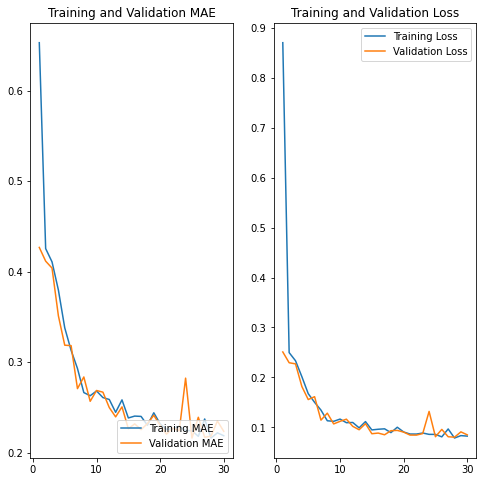

Accuracy is:  0.9785


(<tensorflow.python.keras.callbacks.History at 0x7fc2f04da9b0>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f04fe588>)

In [0]:
create_model_and_train(*data, [], data_augment=True)

Si ha ancora un miglioramento rispetto alla baseline, seppure inferiore al caso precedente. Si nota inoltre una riduzione significativa del gap di generalizzazione, dovuto alla *data augmentation*.

# Altre funzioni di attivazione

Alleno la rete con funzione di attivazione *Leaky ReLu*.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
l_relu_1 (LeakyReLU)         (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
l_relu_2 (LeakyReLU)         (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

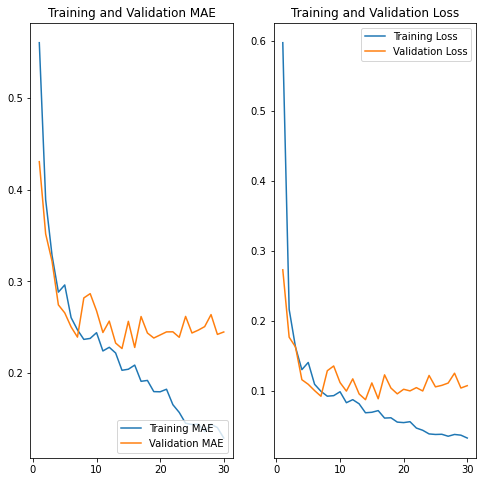

Accuracy is:  0.977


(<tensorflow.python.keras.callbacks.History at 0x7fc2f012c630>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f02c0240>)

In [0]:
create_model_and_train(*data, [], activation="l_relu")

Si nota come con la *Leaky ReLu* l'errore di validazione cominci a crescere prima, si ha quindi overfitting precoce.

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
elu_1 (ELU)                  (None, 26, 26, 32)        0         
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
elu_2 (ELU)                  (None, 11, 11, 64)        0         
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 5, 5, 64)          0 

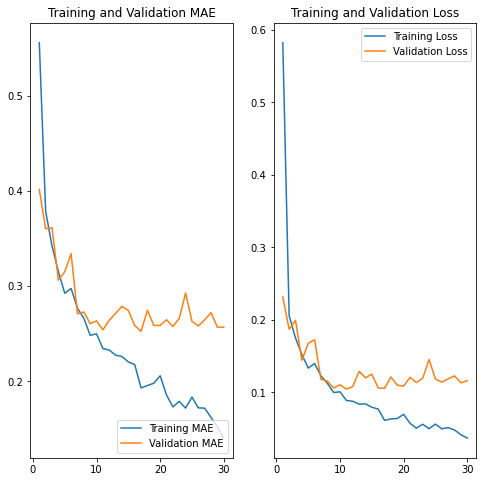

Accuracy is:  0.9635


(<tensorflow.python.keras.callbacks.History at 0x7fc2f105ce48>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2f01ea6d8>)

In [0]:
create_model_and_train(*data, [], activation="elu")

Un fenomeno simile si ha con la *ELu*.

# Batch Normalization

Model: "ising_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
relu_1 (ReLU)                (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
relu_2 (ReLU)                (None, 11, 11, 64)        0 

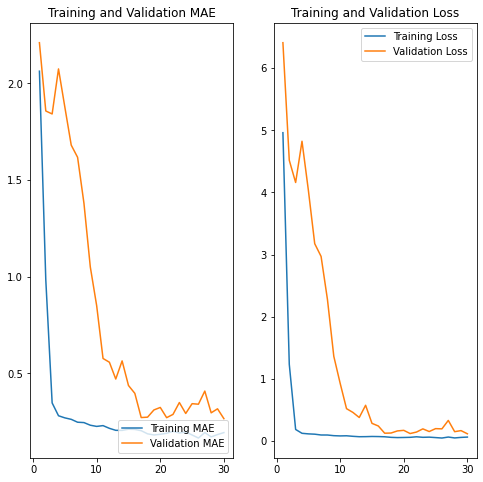

Accuracy is:  0.9835


(<tensorflow.python.keras.callbacks.History at 0x7fc2ea33a3c8>,
 <tensorflow.python.keras.engine.training.Model at 0x7fc2ea464e10>)

In [0]:
create_model_and_train(*data, [], batch_normalize=True)

Si nota un grande aumento dell'errore di generalizzazione, a discapito di una convergenza molto accelerata, con una *training loss* che diventa quasi statica dopo poche epoche. Probabilmente alzando il *learning rate* la situazione migliora.

# Keras Tuner

Provo con un tuning dei seguenti iperparametri:<br>
* learning rate: sampling logaritmico intorno a $10^{-3}$
* ampiezza dei filtri convoluzionali: 2, 3 o 4
* numero di filtri convoluzionali: 16, 32 o 64
* batch normalization: attiva o disattiva
* numero di neuroni nei layer densi: 64, 128, 256

<br>
Le reti che verranno testate hanno quindi in media meno parametri della baseline in modo da provare ad ottenere un effetto di regolarizzazione.

In [0]:
# definizione del modello (come esempio qui una versione semplificata del nostro modello)

def build_model(hp):
  inputs = keras.Input(shape=(28,28,1))

  data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip()
  ], name='DataAugm')

  activation = "relu"

  x = data_augmentation(inputs)

  batch_normalize = hp.Choice("batch_normalize", values=[True, False])
  if batch_normalize:
    layer_with_activation = lambda name, x: \
      keras.layers.BatchNormalization()(keras.layers.ReLU(name=name)(x))
  else:
    layer_with_activation = lambda name, x: \
      keras.layers.ReLU(name=name)(x)

  ks = hp.Choice("kernel_size", values=[2, 3, 4])
  f1 = hp.Choice("filter", values=[16, 32, 64])
  x = keras.layers.Conv2D(f1, kernel_size=(ks,ks), name='Conv_1')(x)
  x = layer_with_activation(f'{activation}_1', x)
  x = keras.layers.MaxPooling2D((2,2), name='MaxPool_1')(x)
  x = keras.layers.Conv2D(f1, kernel_size=(ks,ks), name='Conv_2')(x)
  x = layer_with_activation(f'{activation}_2', x)
  x = keras.layers.MaxPooling2D((2,2), name='MaxPool_2')(x)

  x = keras.layers.Conv2D(f1, kernel_size=(ks,ks), name='Conv_3')(x)
  x = layer_with_activation(f'{activation}_3', x)

  x = keras.layers.Flatten(name='Flatten')(x)

  dense_n = hp.Choice("dense_n", values=[64, 128, 256])
  x = keras.layers.Dense(dense_n, name='Dense_1')(x)
  x = layer_with_activation(f'{activation}_dense_1', x)
  x = keras.layers.Dense(dense_n, name='Dense_2')(x)
  x = layer_with_activation(f'{activation}_dense_2', x)
  outputs = keras.layers.Dense(1, name='Output')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  
  model.compile(
        optimizer=keras.optimizers.Adam(
          hp.Float("learning rate", min_value=3e-4, max_value=5e-3, sampling="LOG")),
        loss='mse',
        metrics=['mae'])
  return model

In [0]:
pip install -U keras-tuner

     |████████████████████████████████| 61kB 9.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=e3452d13986a9abb1c41663cc655fd1e072a81fda3ea65d55e438d0fe80413a3
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=2f0780b9c28434687b10af341aca65fb4a335dab6fee25207ae2f638fa1a5acf
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


Come tuner utilizzo Hyperband, ottimizzando rispetto al *MAE* di validazione.

In [0]:
# definizione del tuner 
# vari tuner a disposizione RandomSearch, Hyeprband (http://jmlr.org/papers/v18/16-558.html), ...
import kerastuner
 
tuner = kerastuner.tuners.Hyperband(
  build_model,
  objective='val_mae',
  executions_per_trial=2,
  directory='hyperband',
  max_epochs=40)

Sintesi della ricerca che verrà effettuata.

In [0]:
tuner.search_space_summary()

Imposto la ricerca con *early stopping*, settato a patience=5 (anche questo iperparametro andrebbe testato).

In [0]:
tuner.search(X_train, Y_train, 
             epochs=50, validation_split=0.1, 
             callbacks=[tf.keras.callbacks.EarlyStopping('val_mae', patience=5)]
             )

Il migliore modello trovato non ha *batch normalization*, ha pochi neuroni nei layer densi (64) rispetto alla baseline con 256, ha sempre layer convoluzionali da 64 filtri (rispetto alla baseline con 32 o 64) con ampiezza del kernel 2x2 (rispetto alla baseline con 3x3). Si ha quindi una rete con convoluzioni più strette e profonde e una certa minimalità nei layer densi.

In [0]:
# Results
tuner.results_summary(num_trials=1)

In [0]:
# Retrieve the best models
models = tuner.get_best_models(num_models=1)
test_loss, test_mae = models[0].evaluate(X_test,  Y_test, verbose=2)

In [0]:
print('Test loss (MSE):', test_loss)
print('\nTest MAE:', test_mae)

Test loss (MSE): 0.06814267486333847

Test MAE: 0.1982106864452362


Le prestazioni ottenute sono le migliori finora. Si può notare come il tuning abbia escluso la batch normalization, in modo abbastanza sorprendente. Ciò può essere imputato alla scelta di learning rate mediamente troppo piccoli: la batch normalization infatti ha un effetto di smoothing sul landscape delle loss function e di accelerazione del training che incoraggia l'uso di learning rate più alti del normale. <br>
Inoltre il tuning ha determinato come ottimale la scelta di layer densi con pochi neuroni, probabilmente a causa del limitato numero di epoche impostato, in congiunzione con la bassa complessità del dataset e la implicita richiesta di minimizzazione insita nell'aver ottimizzato la rete rispetto all'errore di validation.